## Traditional ML classification models under wavelet analysis structures

In [1]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

### Implementations
#### Read Data

In [2]:
# Configurations - Feature names
LOWLUX = 'lowlux'
MIDLUX = 'middlelux'
HIGHLUX = 'highlux'
NOBACK = 'nothing'
ONEBACK = 'ONEBACK'
TWOBACK = 'TWOBACK'
THREEBACK = 'THREEBACK'
FILENAME = 'Filename'
IPA2 = 'IPA 2'
INDEX = 'index'
LUX = 'Luminance'
LABELS = 'Labels'
ISBLINK_LEFT = 'isBlink-Left'
ISBLINK_RIGHT = 'isBlink-Right'
PID = 'PID'
AVE_DM = 'Averaged Diameter'
DIFF_DM = 'Difference Diameter'

# Training and testing ratio.
TEST_SIZE_PCT = 0.1

# Setting thresholds for 2 eyes' blinking rates.
THRES_BLINKING_RATE = 0.3 # The default value.

In [3]:
# Read data and make them into processable formalities.
filepath = '../Data/Results/21-11-13-13/results.csv'
df_raw_features = pd.read_csv(filepath)

In [4]:
df_raw_features

,Left-0,Left-1,Left-2,Left-3,Left-4,Left-5,Left-6,Left-7,Left-8,Left-9,...,Right-147,Right-148,Right-149,Averaged Diameter,Difference Diameter,isBlink-Left,isBlink-Right,Luminance,PID,Labels
0,90.878101,90.000122,89.429937,90.488841,90.425234,90.336186,90.534690,90.501258,90.304912,90.299277,...,94.824154,95.681502,95.550234,46.214449,-2.993481,0.325000,0.370000,lowlux,7,nothing
1,90.272990,90.943095,90.475785,90.534682,90.372235,90.283447,90.175733,90.071457,89.966849,89.862239,...,94.965808,95.486500,94.833888,46.102734,-2.943094,0.168333,0.203333,lowlux,7,nothing
2,89.356322,88.406687,88.938648,89.101954,88.632723,89.213376,88.886822,88.681709,89.061931,88.684184,...,96.326834,96.544795,95.752655,46.330987,-3.043528,0.000000,0.000000,lowlux,7,nothing
3,89.591427,90.381350,89.822829,90.178344,90.201855,90.039328,89.327095,90.271126,89.445756,89.488081,...,94.325592,93.692027,93.015056,46.389218,-2.974158,0.135000,0.195000,lowlux,7,nothing
4,89.352206,89.354459,90.085756,90.154200,90.493916,88.939724,89.547730,90.279304,90.332414,91.536459,...,93.245723,93.272628,94.553329,45.993263,-2.558402,0.135000,0.195000,lowlux,7,nothing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2807,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,91.581850,91.573155,91.780403,46.211527,0.826298,1.000000,0.431667,lowlux,2,THREEBACK
2808,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,91.303723,91.315547,91.318091,46.219696,0.809960,1.000000,0.530000,lowlux,2,THREEBACK
2809,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,91.241145,91.231029,91.214267,46.202013,0.845325,1.000000,0.663333,lowlux,2,THREEBACK
2810,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,89.802735,90.034177,89.511720,46.105213,1.038926,1.000000,0.816667,lowlux,2,THREEBACK


#### Encoder

This part encodes features into numeric values.

In [5]:
# Encoding and Labeling
luxes = []
nbacks = []
df_numeric_features = df_raw_features.copy()

for index, row in df_numeric_features.iterrows():
    # Label luxes
    if LOWLUX in row[LUX]:
        luxes.append(30)
    elif MIDLUX in row[LUX]:
        luxes.append(4500)
    elif HIGHLUX in row[LUX]:
        luxes.append(15000)
    
    # Label task difficulties
    if NOBACK in row[LABELS]:
        nbacks.append(0)
    elif ONEBACK in row[LABELS]:
        nbacks.append(1)
    elif TWOBACK in row[LABELS]:
        nbacks.append(2)
    elif THREEBACK in row[LABELS]:
        nbacks.append(3)
        
df_numeric_features[LUX] = luxes
df_numeric_features[LABELS] = nbacks

In [6]:
df_numeric_features

,Left-0,Left-1,Left-2,Left-3,Left-4,Left-5,Left-6,Left-7,Left-8,Left-9,...,Right-147,Right-148,Right-149,Averaged Diameter,Difference Diameter,isBlink-Left,isBlink-Right,Luminance,PID,Labels
0,90.878101,90.000122,89.429937,90.488841,90.425234,90.336186,90.534690,90.501258,90.304912,90.299277,...,94.824154,95.681502,95.550234,46.214449,-2.993481,0.325000,0.370000,30,7,0
1,90.272990,90.943095,90.475785,90.534682,90.372235,90.283447,90.175733,90.071457,89.966849,89.862239,...,94.965808,95.486500,94.833888,46.102734,-2.943094,0.168333,0.203333,30,7,0
2,89.356322,88.406687,88.938648,89.101954,88.632723,89.213376,88.886822,88.681709,89.061931,88.684184,...,96.326834,96.544795,95.752655,46.330987,-3.043528,0.000000,0.000000,30,7,0
3,89.591427,90.381350,89.822829,90.178344,90.201855,90.039328,89.327095,90.271126,89.445756,89.488081,...,94.325592,93.692027,93.015056,46.389218,-2.974158,0.135000,0.195000,30,7,0
4,89.352206,89.354459,90.085756,90.154200,90.493916,88.939724,89.547730,90.279304,90.332414,91.536459,...,93.245723,93.272628,94.553329,45.993263,-2.558402,0.135000,0.195000,30,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2807,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,91.581850,91.573155,91.780403,46.211527,0.826298,1.000000,0.431667,30,2,3
2808,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,91.303723,91.315547,91.318091,46.219696,0.809960,1.000000,0.530000,30,2,3
2809,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,91.241145,91.231029,91.214267,46.202013,0.845325,1.000000,0.663333,30,2,3
2810,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,89.802735,90.034177,89.511720,46.105213,1.038926,1.000000,0.816667,30,2,3


#### Data visualization

In [7]:
# sns.pairplot(df_labels_IPA2, hue=LABELS)

#### Implementing with a encapsulated function.

In [8]:
def ml_pipeline(df_input):
    df = df_input.copy()
    # Feature selection
    # Remove PID label / feature.
    df = df.loc[:, df.columns != PID]
    
    # Remove lux
    df = df.loc[:, df.columns != LUX]
    
    # Remove blinks.
    before_blinking_filter = len(df)
    df = df.loc[df[ISBLINK_LEFT] <= THRES_BLINKING_RATE]
    df = df.loc[df[ISBLINK_RIGHT] <= THRES_BLINKING_RATE]
    after_blinking_filter = len(df)
    lost_data_num = before_blinking_filter - after_blinking_filter
    print('Before there was: ' + str(before_blinking_filter) + ' instances, then there is : ' + str(after_blinking_filter) + ' instances. ' + str(lost_data_num) + ' instances are lost.')
#     df = df.reset_index()  # This will add a feature column index to the dataset, and increases accuracy largely for KNN model. Comment this line. While SVM was less affected by KNN. 
    
    # Remove the blinking rates related features.
    df = df.loc[:, df.columns != ISBLINK_LEFT]
    df = df.loc[:, df.columns != ISBLINK_RIGHT]
    
    # Split dataset.
    # Get the X and y sets.
    X = df.loc[:, df.columns != LABELS].to_numpy()
    y = df.loc[:, df.columns == LABELS].to_numpy()
    y = np.reshape(y, -1)
    
    # Split the data into training dataset and validation dataset.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE_PCT, random_state=999)
    
    # Train with models.
    # SVM model. TODO: try the SVM model mentioned in 2022 ISMAR and boosting method, and also feature selection method.
    # Try SVM, bacause it is one of the most widely used models in cognitive workload claissfications.
    clf_svm = make_pipeline(StandardScaler(),SVC(kernel='poly', degree=7)) #SVC(kernel='rbf', gamma='auto'))
    clf_svm.fit(X_train, y_train)

    y_pred_svm = clf_svm.predict(X_test)

    score_svm = accuracy_score(y_test, y_pred_svm)
    
    # Get the confusion matrix.
    cm_svm = confusion_matrix(y_test, y_pred_svm)
    cm_display_svm = ConfusionMatrixDisplay(cm_svm).plot() # These parts could be written in a function later as models increases.
    
    # KNN model.
    # Train the model.
    clf_neigh = KNeighborsClassifier(n_neighbors=5)
    clf_neigh.fit(X_train, y_train)

    # Test.
    y_pred_knn = clf_neigh.predict(X_test)
    # print(y_pred, y_test)

    # Accuracy score calculation.
    score_neigh = accuracy_score(y_test, y_pred_knn)
    
    # Get the confusion matrix.
    cm_knn = confusion_matrix(y_test, y_pred_knn)
    cm_display_knn = ConfusionMatrixDisplay(cm_knn).plot()
    
    # Print the results.
    print('The SVM result is: ' + str(score_svm) +  '\n The KNN result is: ' + str(score_neigh))
    
    df_output = df.copy()
    return df_output

#### Machine Learning Implementations

Wall time: 0 ns
The baseline results: 
Before there was: 2812 instances, then there is : 1300 instances. 1512 instances are lost.
The SVM result is: 0.35384615384615387
 The KNN result is: 0.6
The proposed features results: 
Before there was: 2812 instances, then there is : 1300 instances. 1512 instances are lost.
The SVM result is: 0.3230769230769231
 The KNN result is: 0.5769230769230769


,Left-0,Left-1,Left-2,Left-3,Left-4,Left-5,Left-6,Left-7,Left-8,Left-9,...,Right-143,Right-144,Right-145,Right-146,Right-147,Right-148,Right-149,Averaged Diameter,Difference Diameter,Labels
1,90.272990,90.943095,90.475785,90.534682,90.372235,90.283447,90.175733,90.071457,89.966849,89.862239,...,96.071054,96.060319,96.455060,95.353432,94.965808,95.486500,94.833888,46.102734,-2.943094,0
2,89.356322,88.406687,88.938648,89.101954,88.632723,89.213376,88.886822,88.681709,89.061931,88.684184,...,96.417453,96.021787,95.822918,96.589191,96.326834,96.544795,95.752655,46.330987,-3.043528,0
3,89.591427,90.381350,89.822829,90.178344,90.201855,90.039328,89.327095,90.271126,89.445756,89.488081,...,94.038528,93.704864,93.682537,93.863888,94.325592,93.692027,93.015056,46.389218,-2.974158,0
4,89.352206,89.354459,90.085756,90.154200,90.493916,88.939724,89.547730,90.279304,90.332414,91.536459,...,93.067007,92.972109,93.907159,92.912075,93.245723,93.272628,94.553329,45.993263,-2.558402,0
5,90.190303,89.699041,89.647380,89.442384,89.303757,89.144539,88.990699,88.835912,88.681113,88.527209,...,95.488780,95.294508,95.565274,95.277955,95.684226,95.974496,95.126374,45.605047,-2.592870,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2626,88.243316,87.353155,87.451355,87.116847,87.064689,86.946510,87.404427,87.023425,87.494278,86.908700,...,86.260639,85.857701,85.633933,85.766516,85.820228,86.067686,86.231912,42.890241,0.911319,1
2627,87.371180,86.022198,86.176763,86.152101,86.307234,86.083863,86.151947,86.195246,86.184480,85.946994,...,86.704565,86.428806,86.796015,86.579787,86.843397,86.822470,87.066159,43.455088,1.071264,1
2659,91.093841,88.252200,88.838610,88.739409,88.420796,88.599997,88.528706,88.951519,88.758912,88.859269,...,90.024164,89.995999,89.978726,89.923543,89.969786,89.864344,90.181038,45.114455,2.676425,2
2768,92.739069,93.212414,93.097705,93.173248,93.159971,93.173350,93.179739,93.187358,93.194844,93.202354,...,88.118929,88.118113,88.113437,88.121843,88.096310,88.116641,88.000582,45.265889,2.402693,3


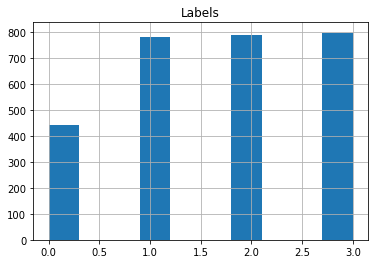

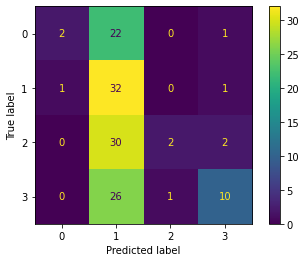

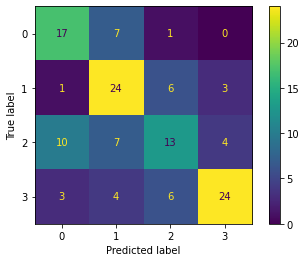

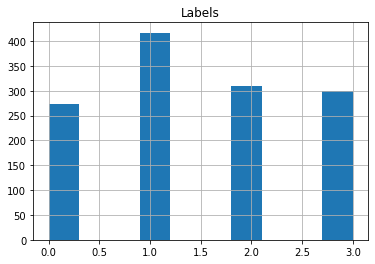

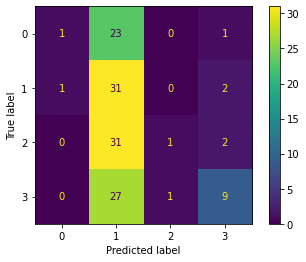

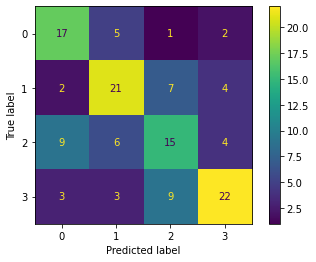

In [9]:
%time
# Test: time-domain feature sets.
time_domain_features = [AVE_DM, DIFF_DM, ISBLINK_LEFT, ISBLINK_RIGHT, LUX, PID, LABELS]
df_baseline_time_features = df_numeric_features[time_domain_features].copy()

# Looping and fine-tuning hyper-parameters. TODO


# Compare different features.
df_baseline_time_features.hist(column=LABELS)
print('The baseline results: ')
df_used_features = ml_pipeline(df_input=df_baseline_time_features)
df_used_features.hist(column=LABELS)

print('The proposed features results: ')
ml_pipeline(df_input=df_numeric_features)

In [10]:
# Now the best parameter set:
# param = {train_test_size = 0.1, threshold_blinking_rate=0.7, SVM acc=0.4333, knn_num_neighbor=5, knn acc=0.86699}